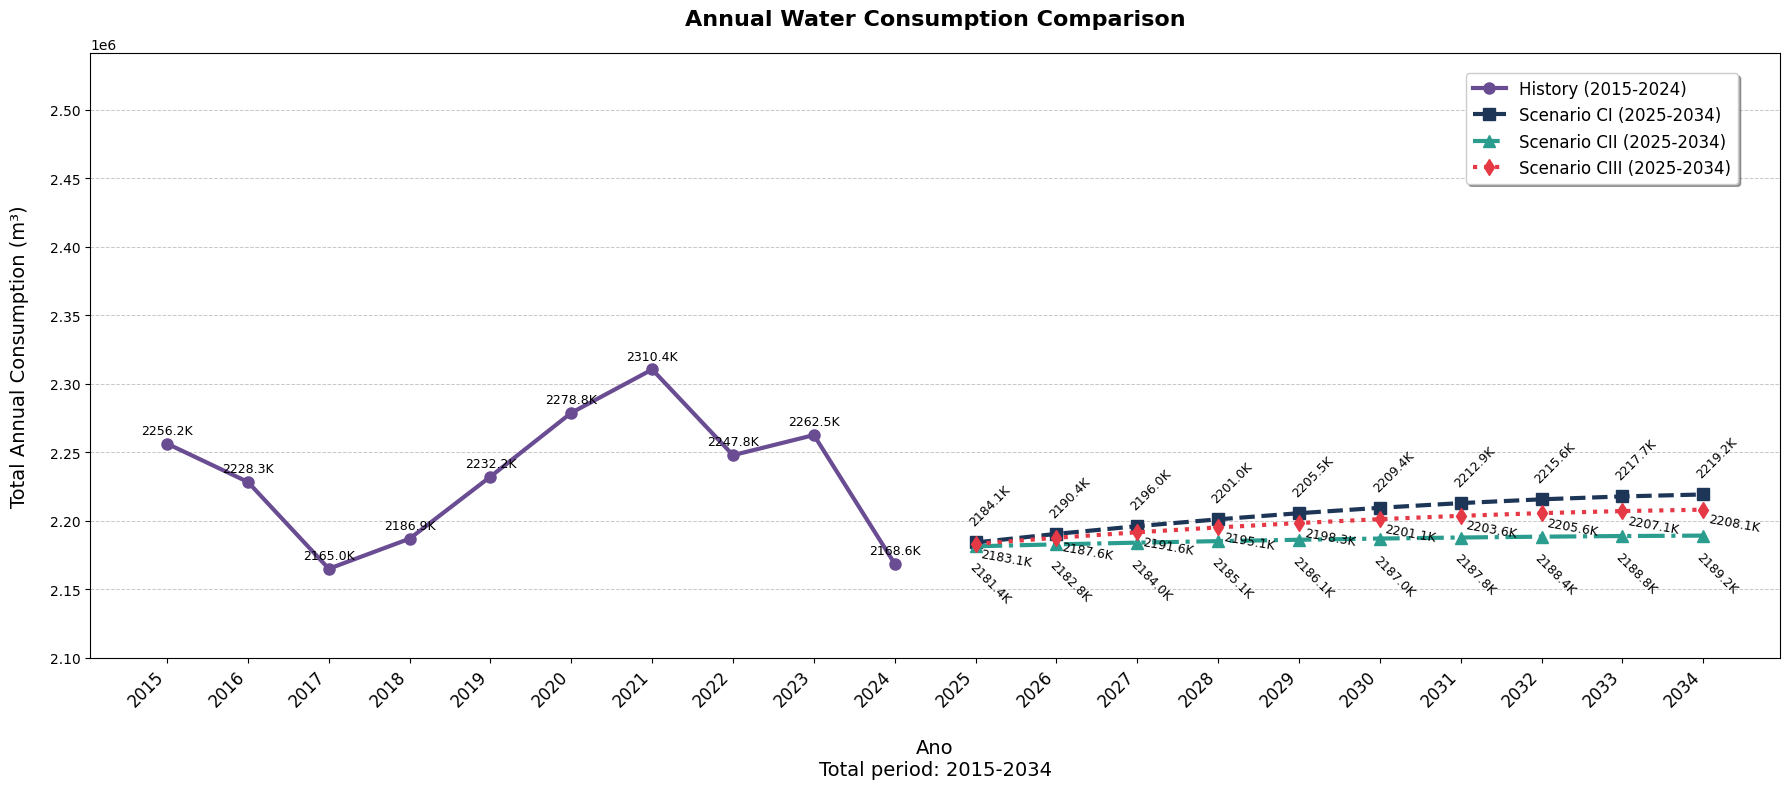

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

path = 'C:\\Users\\Edmilson\\Gama_Workspace2\\ABMS-WP'

# 1. Carregar e processar dados
scenario_file = os.path.join(path, 'resultados\\dados_simulacao3.csv')
df_scenarios = pd.read_csv(scenario_file)
df_scenarios.columns = ['Month/Year', 'Scenario CI', 'Scenario CII', 'Scenario CIII']
df_scenarios['Date'] = pd.to_datetime(df_scenarios['Month/Year'], format='%m/%Y')

historical_file = os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m_por_mes.csv')
df_historical = pd.read_csv(historical_file, sep=';')
df_historical['Date'] = pd.to_datetime(df_historical['data'])
df_historical.rename(columns={'consumo': 'Historical Consumption'}, inplace=True)

# 2. Filtrar dados até 2034
df_scenarios = df_scenarios[df_scenarios['Date'] < pd.to_datetime('2035-01-01')]

# 3. Função para somar dados anualmente
def sum_yearly(df, value_column):
    df_year = df.copy()
    df_year['Year'] = df_year['Date'].dt.year
    return df_year.groupby('Year')[value_column].sum().reset_index()

# 4. Somar dados anualmente
df_historical_sum = sum_yearly(df_historical, 'Historical Consumption')
df_ci_sum = sum_yearly(df_scenarios[['Date', 'Scenario CI']].rename(columns={'Scenario CI': 'Value'}), 'Value')
df_cii_sum = sum_yearly(df_scenarios[['Date', 'Scenario CII']].rename(columns={'Scenario CII': 'Value'}), 'Value')
df_ciii_sum = sum_yearly(df_scenarios[['Date', 'Scenario CIII']].rename(columns={'Scenario CIII': 'Value'}), 'Value')

# 5. Combinar todos os dados
df_combined = pd.DataFrame({
    'Year': pd.concat([df_historical_sum['Year'], df_ci_sum['Year']]).unique(),
    'Historical': df_historical_sum.set_index('Year')['Historical Consumption'],
    'Scenario CI': df_ci_sum.set_index('Year')['Value'],
    'Scenario CII': df_cii_sum.set_index('Year')['Value'],
    'Scenario CIII': df_ciii_sum.set_index('Year')['Value']
}).reset_index(drop=True).sort_values('Year')

# 6. Determinar períodos
historical_period = f"{df_historical['Date'].dt.year.min()}-{df_historical['Date'].dt.year.max()}"
scenario_period = f"{df_scenarios['Date'].dt.year.min()}-{df_scenarios['Date'].dt.year.max()}"

# 7. Configurar o gráfico de linhas
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Cores e estilo
colors = {
    'Historical': '#6A4C93',
    'Scenario CI': '#1D3557',
    'Scenario CII': '#2A9D8F',
    'Scenario CIII': '#E63946'
}

line_styles = {
    'Historical': '-',
    'Scenario CI': '--',
    'Scenario CII': '-.',
    'Scenario CIII': ':'
}

# 8. Plotar as linhas
line_hist = ax.plot(df_combined['Year'], df_combined['Historical'], 
                   color=colors['Historical'], linestyle=line_styles['Historical'],
                   linewidth=3, marker='o', markersize=8,
                   label=f'History ({historical_period})')[0]
line_ci = ax.plot(df_combined['Year'], df_combined['Scenario CI'], 
                 color=colors['Scenario CI'], linestyle=line_styles['Scenario CI'],
                 linewidth=3, marker='s', markersize=8,
                 label=f'Scenario CI ({scenario_period})')[0]
line_cii = ax.plot(df_combined['Year'], df_combined['Scenario CII'], 
                  color=colors['Scenario CII'], linestyle=line_styles['Scenario CII'],
                  linewidth=3, marker='^', markersize=8,
                  label=f'Scenario CII ({scenario_period})')[0]
line_ciii = ax.plot(df_combined['Year'], df_combined['Scenario CIII'], 
                   color=colors['Scenario CIII'], linestyle=line_styles['Scenario CIII'],
                   linewidth=3, marker='d', markersize=8,
                   label=f'Scenario CIII ({scenario_period})')[0]

# 9. Configurar eixos
ax.set_xticks(df_combined['Year'])
ax.set_xticklabels(df_combined['Year'], rotation=45, ha='right', fontsize=12)
full_period = f"Total period: {df_combined['Year'].min()}-{df_combined['Year'].max()}"
ax.set_xlabel(f"Ano\n{full_period}", fontsize=14, labelpad=20)
plt.ylabel('Total Annual Consumption (m³)', fontsize=14, labelpad=15)
plt.title('Annual Water Consumption Comparison', fontsize=16, pad=20, fontweight='bold')

# 10. Adicionar valores nos pontos com orientações personalizadas
def add_custom_labels():
    for year, h_val, ci_val, cii_val, ciii_val in zip(df_combined['Year'], 
                                                     df_combined['Historical'], 
                                                     df_combined['Scenario CI'], 
                                                     df_combined['Scenario CII'], 
                                                     df_combined['Scenario CIII']):
        if not pd.isna(h_val):
            ax.annotate(f'{h_val/1000:.1f}K', (year, h_val),
                       textcoords="offset points", xytext=(0,5),
                       ha='center', va='bottom', fontsize=9)
        
        if not pd.isna(ci_val):
            ax.annotate(f'{ci_val/1000:.1f}K', (year, ci_val),
                       textcoords="offset points", xytext=(10,10),
                       ha='center', va='bottom', fontsize=9, rotation=45)  # CI: +45°
            
        if not pd.isna(cii_val):
            ax.annotate(f'{cii_val/1000:.1f}K', (year, cii_val),
                       textcoords="offset points", xytext=(10,-10),
                       ha='center', va='top', fontsize=9, rotation=-45)  # CII: -45°
            
        if not pd.isna(ciii_val):
            ax.annotate(f'{ciii_val/1000:.1f}K', (year, ciii_val),
                       textcoords="offset points", xytext=(3,-2),  # Ajuste para ficar mais próximo
                       ha='left', va='top', fontsize=9, rotation=-10)  # CIII: -15°

add_custom_labels()

# 11. Elementos adicionais com legenda interna
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, axis='y')

# Mover a legenda para dentro do gráfico no canto superior direito
plt.legend(fontsize=12, framealpha=1, shadow=True, 
           loc='upper right', bbox_to_anchor=(0.98, 0.98),
           borderaxespad=0.5)

# Ajustar eixo Y
ymin = 2100000  # 2.1 milhões
ymax = df_combined[['Historical', 'Scenario CI', 'Scenario CII', 'Scenario CIII']].max().max() * 1.1
ax.set_ylim(ymin, ymax)

# Ajustar margens para garantir que a legenda não cubra dados importantes
plt.subplots_adjust(right=0.85)  # Reduzir margem direita

plt.tight_layout()
plt.show()